In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from models import *
from data_generation import *
from utils import *
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.dim_reduction import FPCA

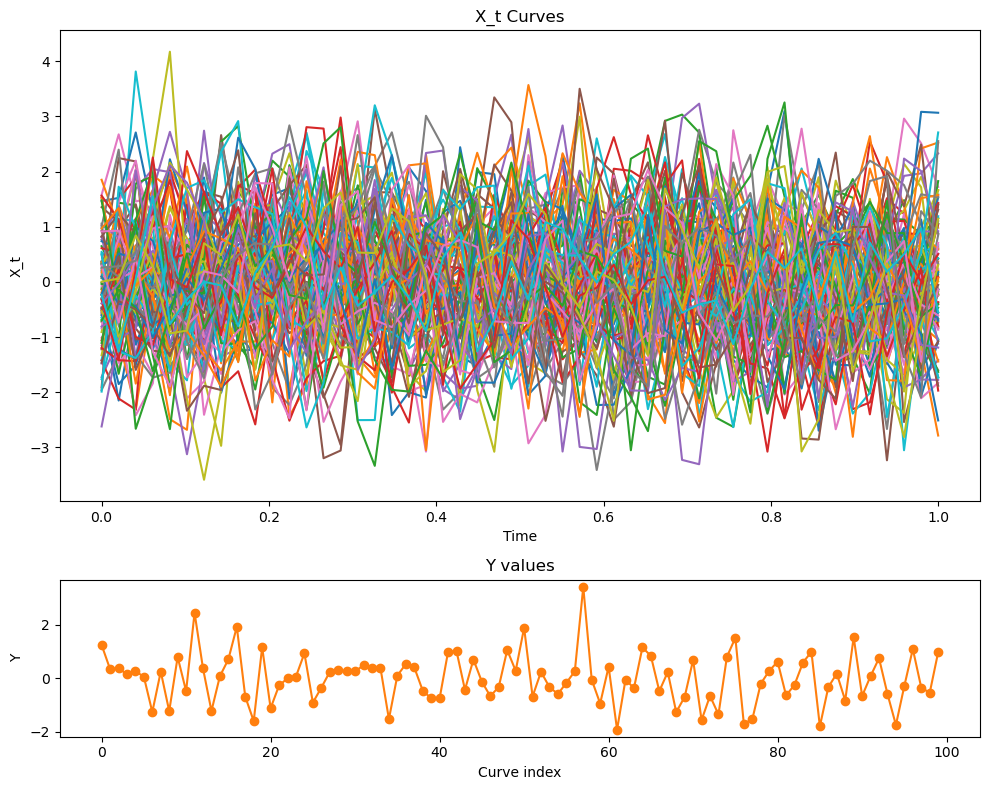

Dimension of X: (50, 100)
Dimension of Y: (100,)


In [2]:
# Example 1: No interactions of Xt
d = 100; theta = 0.5;J = 3;n=50
time_grid = np.linspace(0, 1, n)
X_np, Y_np = generate_Y_case1(d, theta, J, n, plot=True)
print("Dimension of X:", X_np.shape)
print("Dimension of Y:", Y_np.shape)


In [3]:
X_np
print(np.shape(X_np))

(50, 100)


In [4]:
#X.np = X.detach().cpu()
#X.np = X.np.numpy()
#print(np.shape(X.np))

In [5]:
#Step 1: Fit B-spline basis functions to each curve
fd = FDataGrid(data_matrix = X_np.T, grid_points = time_grid)
n_basis = 8  # Number of basis functions
spline_basis = BSplineBasis(n_basis=n_basis, domain_range=(0, 1))
smoother = BasisSmoother(basis=spline_basis)

In [6]:
# Apply smoothing to each curve (column of x)
smoothed_fd = smoother.fit_transform(fd)

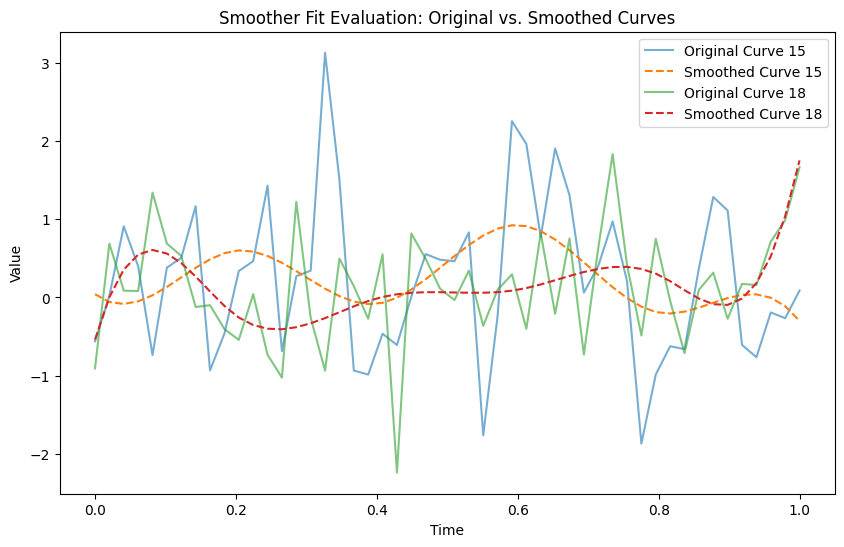

In [8]:
num_curves_to_plot = 2  # Number of curves to visualize
selected_indices = np.random.choice(fd.n_samples, size=num_curves_to_plot, replace=False)  # Randomly select curves

plt.figure(figsize=(10, 6))
for idx in selected_indices:
    original_curve = fd.data_matrix[idx]
    smoothed_curve = smoothed_fd.data_matrix[idx]
    
    plt.plot(fd.grid_points[0], original_curve.flatten(), label=f"Original Curve {idx}", alpha=0.6)
    plt.plot(smoothed_fd.grid_points[0], smoothed_curve.flatten(), label=f"Smoothed Curve {idx}", linestyle="--")
    
plt.title("Smoother Fit Evaluation: Original vs. Smoothed Curves")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [9]:
fpca = FPCA(n_components=8)  
fpca.fit(smoothed_fd)
scores = fpca.transform(smoothed_fd)
# Explained variance ratio
print("Explained variance by each PC:", fpca.explained_variance_ratio_)
sum(fpca.explained_variance_ratio_)

Explained variance by each PC: [0.18658034 0.16727141 0.144744   0.13542886 0.12690487 0.10600808
 0.07662989 0.05643254]


1.0

In [10]:
scores.shape

(100, 8)

In [11]:
X = torch.tensor(scores.T, dtype=torch.float32) 
X.size()

torch.Size([8, 100])

In [12]:
Y = torch.tensor(Y_np, dtype=torch.float32).view(1, d)
Y.size()

torch.Size([1, 100])

# Model adding covariates

Epoch [10/500], Loss: 0.0840
Epoch [20/500], Loss: 0.0154
Epoch [30/500], Loss: 0.0041
Epoch [40/500], Loss: 0.0015
Epoch [50/500], Loss: 0.0005
Epoch [60/500], Loss: 0.0002
Stopping early at Epoch [68/500], Loss: 0.000081


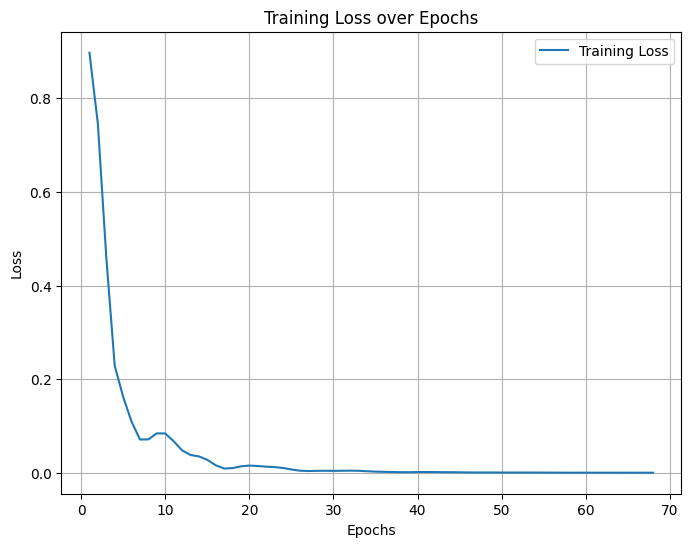

In [13]:
# Train model
q = int(n ** (1/5))  # Setting q as n^(1/5)
h = 1.0  # Example bandwidth

# Define the weight network and the main model
weight_net = WeightNetwork(input_dim=1)  # Neural network to estimate weights
cov_matrix = LR_cov_X(X, q, h, weight_net)  # Long-run covariance matrix with learned weights

x_shape_0 = X.shape[0]
x_shape_1 = X.shape[1]
hidden_dim = 32  # Example hidden layer size
y_shape_0 = Y.shape[0]
y_shape_1 = Y.shape[1]  
cov_dim = d

model = Model1(x_shape_0,x_shape_1, cov_dim, hidden_dim, y_shape_0,y_shape_1)
criterion = nn.MSELoss()
optimizer = optim.Adam(list(model.parameters()) + list(weight_net.parameters()), lr=0.02)

# Training loop
epochs = 500
losses = [] 
for epoch in range(epochs):
    optimizer.zero_grad()
    cov_matrix = LR_cov_X(X, q, h, weight_net)  # Recompute covariance matrix with updated weights
    Y_hat = model(X, cov_matrix)  # Predicted Y(t)
    #print(Y_hat.shape)
    #print(Y.shape)
    loss = criterion(Y_hat, Y)  # Minimize L2 loss between Y_hat and Y
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
     # Check for stopping condition
    if abs(loss.item()) < 1e-4:
        print(f"Stopping early at Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
        break  # Exit the loop when the loss is sufficiently small


    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses) + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()


Shape of Covariance Matrix (NumPy): torch.Size([8, 8])
torch.Size([100])


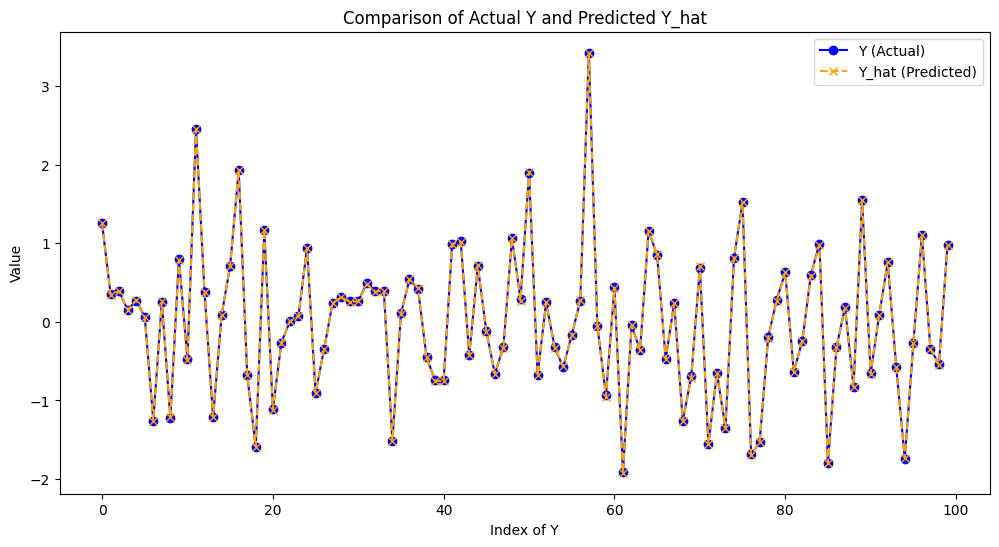

In [14]:
# After training, compute the final predictions for plotting
with torch.no_grad():
    cov_matrix = LR_cov_X(X, q, h, weight_net)
    # Convert to NumPy
    cov_matrix_np = cov_matrix.cpu().numpy()  # Move to CPU and convert to NumPy

    # Print shape of the covariance matrix
    print("\nShape of Covariance Matrix (NumPy):", cov_matrix.size())

    Y_hat = model(X, cov_matrix).view(-1).detach()  # Ensure Y_hat is flattened to match (d,)
    print(Y_hat.size())
    Y_actual = Y.view(-1).detach()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
# Use PyTorch tensors directly for plotting
plt.plot(range(len(Y_actual)), Y_actual.cpu(), label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(len(Y_hat)), Y_hat.cpu(), label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')

plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()

In [15]:
cov_matrix

tensor([[ 3.5939e-02,  4.4017e-03,  5.2477e-03, -7.3034e-03,  3.5754e-03,
          2.4452e-04,  3.0615e-03,  2.0467e-03],
        [ 4.4017e-03,  2.6429e-02,  9.9674e-03, -1.9152e-03,  1.5660e-03,
         -1.2728e-03,  1.9072e-03,  2.1695e-03],
        [ 5.2477e-03,  9.9674e-03,  1.6797e-02, -1.0674e-03,  2.1998e-03,
         -1.4401e-03,  3.6536e-05, -2.0140e-03],
        [-7.3034e-03, -1.9152e-03, -1.0674e-03,  1.8673e-02, -1.9790e-03,
          5.7069e-04, -3.6470e-03, -2.5510e-05],
        [ 3.5754e-03,  1.5660e-03,  2.1998e-03, -1.9790e-03,  1.6136e-02,
          5.3538e-03,  5.3706e-03,  2.7221e-03],
        [ 2.4452e-04, -1.2728e-03, -1.4401e-03,  5.7069e-04,  5.3538e-03,
          4.4000e-03,  4.3095e-03,  1.7171e-03],
        [ 3.0615e-03,  1.9072e-03,  3.6536e-05, -3.6470e-03,  5.3706e-03,
          4.3095e-03,  1.1436e-02,  2.8632e-03],
        [ 2.0467e-03,  2.1695e-03, -2.0140e-03, -2.5510e-05,  2.7221e-03,
          1.7171e-03,  2.8632e-03,  9.1254e-03]])

In [16]:
import os

# Ensure the results directory exists
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Convert the tensor to a NumPy array and save it as a CSV file
cov_matrix_np = cov_matrix.cpu().numpy()  # Convert to NumPy (ensure on CPU first)
csv_path = os.path.join(results_dir, "cov_matrix_case1.csv")

# Save as CSV
np.savetxt(csv_path, cov_matrix_np, delimiter=",", fmt="%.6f")  # Adjust `fmt` for precision

print(f"Covariance matrix saved to {csv_path}")

Covariance matrix saved to results/cov_matrix_case1.csv


# Model without covariates

Stopping early at Epoch [65/1000], Loss: 0.000082


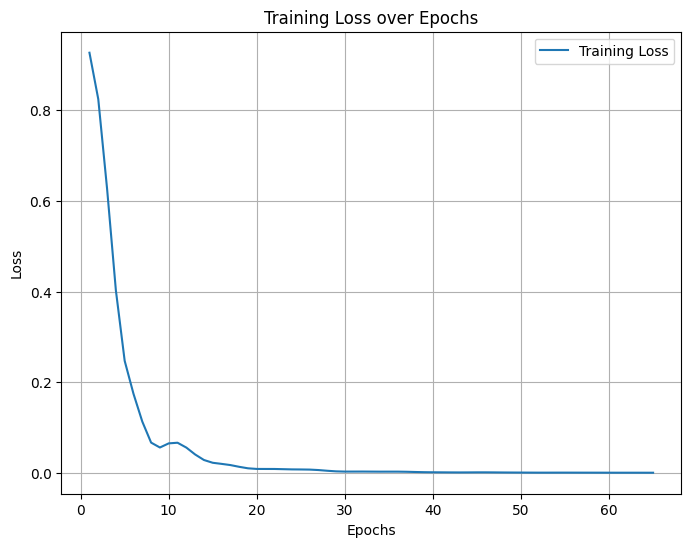

In [17]:
x_shape_0 = X.shape[0]
x_shape_1 = X.shape[1]
hidden_dim = 32  # Example hidden layer size
y_shape_0 = Y.shape[0]
y_shape_1 = Y.shape[1]  


model_nocov = Model1_nocov(x_shape_0,x_shape_1, hidden_dim, y_shape_0,y_shape_1)
criterion_nocov = nn.MSELoss()
optimizer_nocov = optim.Adam(list(model_nocov.parameters()) , lr=0.02)

# Training loop
epochs = 1000
losses_nocov = []
for epoch in range(epochs):
    optimizer_nocov.zero_grad()
    #cov_matrix = LR_cov_X(X, q, h, weight_net)  # Recompute covariance matrix with updated weights
    Y_hat = model_nocov(X)  # Predicted Y(t)
    #print(Y_hat.shape)
    #print(Y.shape)
    loss_nocov = criterion_nocov(Y_hat, Y)  # Minimize L2 loss between Y_hat and Y
    loss_nocov.backward()
    optimizer_nocov.step()
    losses_nocov.append(loss_nocov.item())

    # Check for stopping condition
    if abs(loss_nocov.item()) < 1e-4:
        print(f"Stopping early at Epoch [{epoch+1}/{epochs}], Loss: {loss_nocov.item():.6f}")
        break  # Exit the loop when the loss is sufficiently small


    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss_nocov.item():.4f}')

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses_nocov) + 1), losses_nocov, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

(100,)


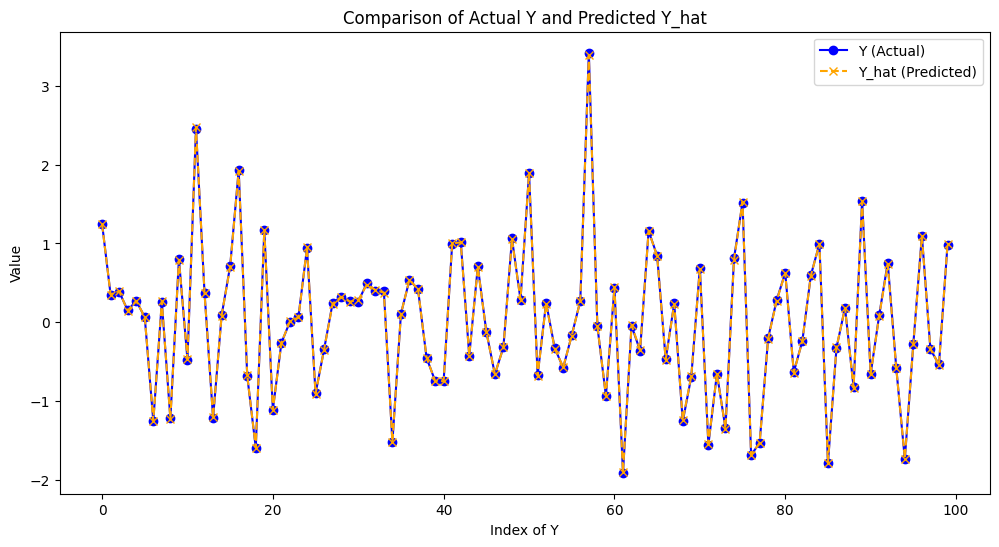

In [18]:
# After training, compute the final predictions for plotting
with torch.no_grad():
    Y_hat = model_nocov(X).view(-1).detach().numpy()  # Ensure Y_hat is flattened to match (d,)
    print(np.shape(Y_hat))
    Y_actual = Y.view(-1).numpy()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
plt.plot(range(d), Y_actual, label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(d), Y_hat, label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')
plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()

In [19]:
X_numpy = X.cpu().numpy()  # Ensure tensor is on CPU before converting to NumPy

X_numpy.shape

(8, 100)

In [22]:
true_cov_matrix = compute_lr_covariance(X_numpy,7)

In [23]:
difference = true_cov_matrix - cov_matrix_np
# Metrics
max_difference = np.max(np.abs(difference))  # Maximum absolute difference
mean_difference = np.mean(difference)       # Mean difference
frobenius_norm = np.linalg.norm(difference, ord='fro')  # Frobenius norm
infinity_norm = np.max(np.sum(np.abs(difference), axis=1))


# Print comparison results
print("Element-wise Difference Matrix:")
print(difference)

print("\nComparison Metrics:")
print(f"Max Absolute Difference: {max_difference}")
print(f"Mean Difference: {mean_difference}")
print(f"Frobenius Norm of Difference: {frobenius_norm}")
print(f"Infinity Norm of Difference: {infinity_norm}")

Element-wise Difference Matrix:
[[ 0.02156454  0.02886886  0.00848549 -0.0016354   0.013801   -0.00997504
  -0.00013056  0.00599518]
 [ 0.02886886  0.03463323  0.0314038  -0.01635238 -0.00629104  0.00044563
   0.00619634 -0.00659217]
 [ 0.00848549  0.0314038   0.02053785  0.00419371 -0.02206716  0.00127681
  -0.01003891 -0.0125655 ]
 [-0.0016354  -0.01635238  0.00419371  0.02151033 -0.02390084  0.01446606
  -0.01199558 -0.01850751]
 [ 0.013801   -0.00629104 -0.02206716 -0.02390084  0.03332994 -0.01828512
   0.00666089  0.00013611]
 [-0.00997504  0.00044563  0.00127681  0.01446606 -0.01828512  0.00897428
  -0.01053656 -0.01129067]
 [-0.00013056  0.00619634 -0.01003891 -0.01199558  0.00666089 -0.01053656
   0.00366992 -0.00444552]
 [ 0.00599518 -0.00659217 -0.0125655  -0.01850751  0.00013611 -0.01129067
  -0.00444552  0.00273195]]

Comparison Metrics:
Max Absolute Difference: 0.0346332264598459
Mean Difference: 0.00033737336532908575
Frobenius Norm of Difference: 0.11965528988941483
Infi